# 초등 돌봄 센터 입지선정 

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import os
from shapely.geometry import Point, Polygon, LineString
from fiona.crs import from_string

## 파일 불러오기

In [70]:
epsg4326 = from_string("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
epsg5179 = from_string("+proj=tmerc +lat_0=38 +lon_0=127.5 +k=0.9996 +x_0=1000000 +y_0=2000000 +ellps=GRS80 +units=m +no_defs")

In [71]:
line22 = gpd.read_file('C:/Users/user/PYTHON/초등 센터 입지선정/원본데이터/달서구행정동shp/bnd_dong_22070_2021_2021_2Q.shp', encoding = 'euc-kr')
child = gpd.read_file('C:/Users/user/PYTHON/초등 센터 입지선정/원본데이터/초등학생 인구 수(전체)-(격자) 100M_대구광역시 달서구_202104/nlsp_021001016.shp', encoding = 'utf-8')
child = child.to_crs(epsg5179)

lib = pd.read_csv('C:/Users/user/PYTHON/초등 센터 입지선정/원본데이터/대구광역시_달서구_도서관_20210331.csv', encoding='cp949', dtype=str)
park = pd.read_csv('C:/Users/user/PYTHON/초등 센터 입지선정/원본데이터/대구광역시_달서구_도시공원정보_20210319_1616636875092_37694.csv', encoding='cp949', dtype=str)
center = pd.read_excel('C:/Users/user/PYTHON/초등 센터 입지선정/원본데이터/지역아동센터 현황(2021. 7.1. 기준).xlsx', dtype=str)
school = pd.read_csv('C:/Users/user/PYTHON/초등 센터 입지선정/원본데이터/한국교원대학교_초중등학교위치_파일데이터_20210915.csv', encoding='cp949', dtype=str)

## 데이터 정제

In [72]:
lib['경도'] = lib['경도'].astype(float)
lib['위도'] = lib['위도'].astype(float)

park['경도'] = park['경도'].astype(float)
park['위도'] = park['위도'].astype(float)

center['lon'] = center['lon'].astype(float)
center['lat'] = center['lat'].astype(float)

school['경도'] = school['경도'].astype(float)
school['위도'] = school['위도'].astype(float)

In [73]:
lib['geometry'] = lib.apply(lambda row : Point([row['경도'], row['위도']]), axis=1)
lib = gpd.GeoDataFrame(lib, geometry='geometry', crs = epsg4326)
lib = lib.to_crs(epsg5179)
lib = lib[['geometry']]

park['geometry'] = park.apply(lambda row : Point([row['경도'], row['위도']]), axis=1)
park = gpd.GeoDataFrame(park, geometry='geometry', crs = epsg4326)
park = park.to_crs(epsg5179)
park = park[['geometry']]

center['geometry'] = center.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)
center = gpd.GeoDataFrame(center, geometry='geometry', crs = epsg4326)
center = center.to_crs(epsg5179)
center = center[['geometry']]

school['geometry'] = school.apply(lambda row : Point([row['경도'], row['위도']]), axis=1)
school = gpd.GeoDataFrame(school, geometry='geometry', crs = epsg4326)
school = school.to_crs(epsg5179)
school = school[['geometry']]

In [74]:
lib['lib_num'] = 1
park['park_num'] = 1
center = center.drop([center.index[0]])  # 한번만 실행해야함

## 데이터 결합

In [75]:
result = gpd.sjoin(child, lib, how='left', op="intersects")
result = result[['gid','val','geometry','lib_num']]

result = gpd.sjoin(result, park, how='left', op="intersects")
result = result[['gid','val','geometry','lib_num','park_num']]

result = result.drop_duplicates(['geometry'], keep='first')

## 돌봄 시설 접근성 결합

In [76]:
center['geometry'] = center.buffer(500)

intersection = gpd.overlay(result, center,  how = 'intersection')
intersection['center'] = intersection['geometry'].area
intersection['center'] = round(intersection['center'],2)
intersection = intersection[intersection['center'] !=0] 
intersection = intersection.groupby(by=['gid'], as_index=False)['center'].sum()
result2 = pd.merge(result, intersection, on = ['gid'], how = 'left')

## 초등학교 접근성 결합

In [77]:
school['geometry'] = school.buffer(500) 

intersection1 = gpd.overlay(result2, school,  how = 'intersection')
intersection1['school'] = intersection1['geometry'].area
intersection1['school'] = round(intersection1['school'],2)
intersection1 = intersection1[intersection1['school'] !=0] 
intersection1 = intersection1.groupby(by=['gid'], as_index=False)['school'].sum()
result3 = pd.merge(result2, intersection1, on = ['gid'], how = 'left')

In [78]:
result3 = result3[['gid','geometry','val','lib_num','park_num','school','center']]

In [79]:
r1 = result3.copy(deep = True)
r1 = r1.dropna(subset=['val','lib_num','park_num','center','school'], how='all')   # 5개 열 모두 nan이면 행 삭제 
r1.iloc[:,2:] = r1.iloc[:,2:].fillna(0)     # nan을 0으로 고치기

In [80]:
r1

,gid,geometry,val,lib_num,park_num,school,center
0,라마910626,"POLYGON ((1091000.000 1762600.000, 1091000.000...",7.0,0.0,1.0,9819.07,10000.0
1,라마947574,"POLYGON ((1094700.000 1757400.000, 1094700.000...",0.0,0.0,0.0,20000.00,10000.0
2,라마951622,"POLYGON ((1095100.000 1762200.000, 1095100.000...",8.0,0.0,0.0,2872.89,10000.0
3,라마932575,"POLYGON ((1093200.000 1757500.000, 1093200.000...",0.0,0.0,0.0,29989.55,20000.0
4,라마926578,"POLYGON ((1092600.000 1757800.000, 1092600.000...",0.0,0.0,0.0,17321.41,10000.0
...,...,...,...,...,...,...,...
6539,라마916588,"POLYGON ((1091600.000 1758800.000, 1091600.000...",0.0,0.0,0.0,10000.00,0.0
6542,라마919632,"POLYGON ((1091900.000 1763200.000, 1091900.000...",0.0,0.0,0.0,20000.00,0.0
6543,라마930586,"POLYGON ((1093000.000 1758600.000, 1093000.000...",0.0,0.0,0.0,28842.35,0.0
6555,라마939608,"POLYGON ((1093900.000 1760800.000, 1093900.000...",0.0,0.0,0.0,865.69,0.0


## 점수화를 위한 함수 설정

In [81]:
def grade_score(x,y):
    df = r1.loc[:,['gid','geometry',x]]
    df = df[df[x] != 0]
    bins = np.linspace(df[x].min(), df[x].max(), 10) 
    df[x +'_bins'] = np.digitize(df[x],bins)
    df = df.loc[:,['gid','geometry',x + '_bins']]
    df2 = pd.merge(r1, df, on = ['gid','geometry'], how = 'left')
    df2[x +'_bins'] = df2[x +'_bins'].fillna(0)
    df2[x +'_bins'] = df2[x +'_bins'].astype(int)
    df2 = df2.loc[:,['gid','geometry',x +'_bins']]
    df2[x +'_bins'] = df2[x +'_bins']*y
    return df2

In [82]:
def lib_num_score(x):
    df = r1.loc[:,['gid','geometry',x]]
    df = df[df[x] != 0]
    bins = np.linspace(df[x].min(), df[x].max(), 7) 
    df[x +'_bins'] = np.digitize(df[x],bins)
    df = df.loc[:,['gid','geometry',x + '_bins']]
    df2 = pd.merge(r1, df, on = ['gid','geometry'], how = 'left')
    df2[x +'_bins'] = df2[x +'_bins'].fillna(0)
    df2[x +'_bins'] = df2[x +'_bins'].astype(int)
    df2 = df2.loc[:,['gid','geometry',x +'_bins']]
    return df2

In [83]:
def park_num_score(x):
    df = r1.loc[:,['gid','geometry',x]]
    df = df[df[x] != 0]
    bins = np.linspace(df[x].min(), df[x].max(), 3) 
    df[x +'_bins'] = np.digitize(df[x],bins)
    df = df.loc[:,['gid','geometry',x + '_bins']]
    df2 = pd.merge(r1, df, on = ['gid','geometry'], how = 'left')
    df2[x +'_bins'] = df2[x +'_bins'].fillna(0)
    df2[x +'_bins'] = df2[x +'_bins'].astype(int)
    df2 = df2.loc[:,['gid','geometry',x +'_bins']]
    return df2

## 가중치 설정

In [84]:
score = grade_score('val',26.2471691)
score2 = lib_num_score('lib_num')
score3 = park_num_score('park_num')
score4 = grade_score('school',39.4670277)
score5 = grade_score('center',16.9334811)

In [85]:
nm = ['score2','score3','score4','score5']
for i in range(len(nm)):
    score = pd.merge(score, locals()[nm[i]], on = ['gid','geometry'], how = 'left')

## 최종 점수화

In [86]:
score['living_bins'] = (score['lib_num_bins']+score['park_num_bins'])* 17.352322
score = score.drop(['lib_num_bins','park_num_bins'], axis=1)
result4 = score.copy(deep=True)
result4['result']= result4['val_bins']+result4['living_bins']+result4['school_bins']-result4['center_bins']
result4['result']=  np.where(result4['result'] < 0, 0, result4['result'] )

In [87]:
result4

,gid,geometry,val_bins,school_bins,center_bins,living_bins,result
0,라마910626,"POLYGON ((1091000.000 1762600.000, 1091000.000...",26.247169,78.934055,50.800443,52.056966,106.437747
1,라마947574,"POLYGON ((1094700.000 1757400.000, 1094700.000...",0.000000,157.868111,50.800443,0.000000,107.067667
2,라마951622,"POLYGON ((1095100.000 1762200.000, 1095100.000...",26.247169,39.467028,50.800443,0.000000,14.913753
3,라마932575,"POLYGON ((1093200.000 1757500.000, 1093200.000...",0.000000,236.802166,84.667406,0.000000,152.134761
4,라마926578,"POLYGON ((1092600.000 1757800.000, 1092600.000...",0.000000,157.868111,50.800443,0.000000,107.067667
...,...,...,...,...,...,...,...
3287,라마916588,"POLYGON ((1091600.000 1758800.000, 1091600.000...",0.000000,78.934055,0.000000,0.000000,78.934055
3288,라마919632,"POLYGON ((1091900.000 1763200.000, 1091900.000...",0.000000,157.868111,0.000000,0.000000,157.868111
3289,라마930586,"POLYGON ((1093000.000 1758600.000, 1093000.000...",0.000000,236.802166,0.000000,0.000000,236.802166
3290,라마939608,"POLYGON ((1093900.000 1760800.000, 1093900.000...",0.000000,39.467028,0.000000,0.000000,39.467028


## 상위 10위

In [88]:
result4['result'].nlargest(10)

1396    528.971293
11      512.056344
984     502.724124
445     473.411784
369     473.026688
379     473.026688
138     463.064549
596     462.627176
821     459.754554
1742    449.792414
Name: result, dtype: float64

## 파일 내보내기

In [89]:
result4.to_file("입지선정결과.shp",  encoding = 'utf-8')

## 시각화 (도서관 및 도시공원)

In [1]:
import pandas as pd
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy.random as nrp
from matplotlib import font_manager, rc
font_location='c:/windows/fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font',family=font_name)

In [3]:
lib = pd.read_csv('도서관 수(최종).csv', encoding = 'ansi' )
park = pd.read_csv('도시공원 수(최종).csv', encoding = 'ansi')

In [8]:
lib_cnt = lib['도서관 수'].value_counts()
park_cnt = park['도시공원 수'].value_counts()

In [9]:
df_lib = pd.DataFrame(lib_cnt)
df_park = pd.DataFrame(park_cnt)

In [11]:
df_lib_final = df_lib.reindex(["성당동", "두류1·2동", "두류3동","본리동","감삼동","죽전동","장기동","용산1동","용산2동","이곡1동","이곡2동","신당동","월성1동","월성2동","진천동","상인1동","상인2동","상인3동","도원동","송현1동","송현2동","본동"])
df_park_final = df_park.reindex(["성당동", "두류1·2동", "두류3동","본리동","감삼동","죽전동","장기동","용산1동","용산2동","이곡1동","이곡2동","신당동","월성1동","월성2동","진천동","상인1동","상인2동","상인3동","도원동","송현1동","송현2동","본동"])

In [67]:
result = pd.concat([df_lib_final,df_park_final],axis=1, join='outer')
result = result.fillna(0).astype(int)

In [17]:
label = ['성당동', '두류1·2동', '두류3동', '본리동', '감삼동','죽전동','장기동','용산1동','용산2동','이곡1동','이곡2동','신당동','월성1동','월성2동','진천동','상인1동','상인2동','상인3동','도원동','송현1동','송현2동','본동']
dong = pd.Series(label)

In [23]:
lib = result.iloc[:,0]
park = result.iloc[:,1]
index = np.arange(len(dong))

<IPython.core.display.Javascript object>


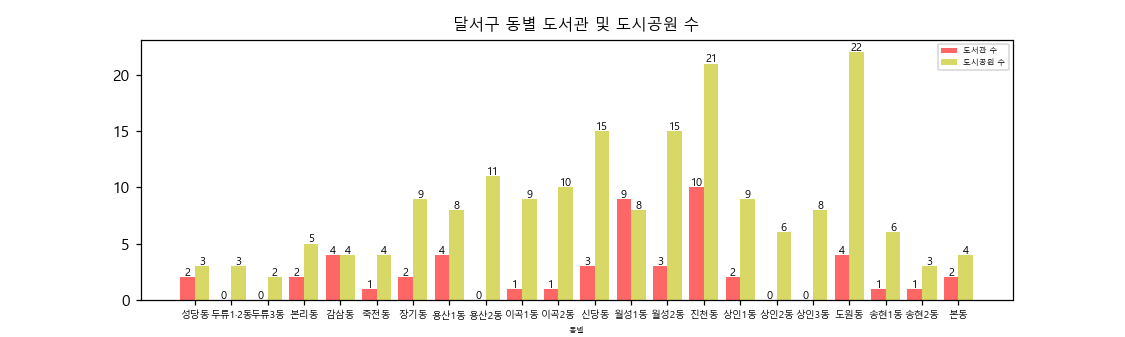

In [27]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot()
bar_width = 0.4
alpha = 0.6

p1 = plt.bar(index, lib, bar_width, color='r', alpha=alpha, label='도서관 수')      #lib

p2 = plt.bar(index + bar_width, park, bar_width, color='y', alpha=alpha, label='도시공원 수')  #park

plt.title('달서구 동별 도서관 및 도시공원 수', fontsize=10)

plt.ylabel('', fontsize=5)

plt.xlabel('동별', fontsize=5)

plt.xticks(index+0.2, label, fontsize=6.3)

plt.legend((p1[0], p2[0]), ('도서관 수', '도시공원 수'), fontsize=5)


num_lib = list(result['도서관 수'])       # num_lib
num_park = list(result['도시공원 수'])      # num_park
 
# xtick_label_position = list(range(len(dong)))
# bars = plt.bar(xtick_label_position, num_patient, alpha=0.7, linewidth=3) ## 바차트 출력
 
for i, a in enumerate(p1):
    ax.text(a.get_x()+a.get_width()*(1/2),a.get_height()+0.08, num_lib[i],ha='center',fontsize=7)     # 
    
for i, b in enumerate(p2):
      ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, num_park[i],ha='center',fontsize=7)   #

plt.show()

## 시각화 (초등학교 및 아동센터)

In [38]:
sch = pd.read_csv('초등학교동별위치행정동(최종).csv', encoding = 'ansi' )
cen = pd.read_csv('아동센터행정동(최종).csv', encoding = 'ansi')

In [34]:
sch_cnt = sch['초등학교 수'].value_counts()
cen_cnt = cen['아동센터 수'].value_counts()

In [35]:
df_sch = pd.DataFrame(sch_cnt)
df_cen = pd.DataFrame(cen_cnt)

In [36]:
df_sch_final = df_sch.reindex(["성당동", "두류1·2동", "두류3동","본리동","감삼동","죽전동","장기동","용산1동","용산2동","이곡1동","이곡2동","신당동","월성1동","월성2동","진천동","상인1동","상인2동","상인3동","도원동","송현1동","송현2동","본동"])
df_cen_final = df_cen.reindex(["성당동", "두류1·2동", "두류3동","본리동","감삼동","죽전동","장기동","용산1동","용산2동","이곡1동","이곡2동","신당동","월성1동","월성2동","진천동","상인1동","상인2동","상인3동","도원동","송현1동","송현2동","본동"])

In [61]:
result2 = pd.concat([df_sch_final,df_cen_final],axis=1, join='outer')
result2 = result2.fillna(0).astype(int)

In [62]:
school = result2.iloc[:,0]
center = result2.iloc[:,1]
index = np.arange(len(dong))

<IPython.core.display.Javascript object>


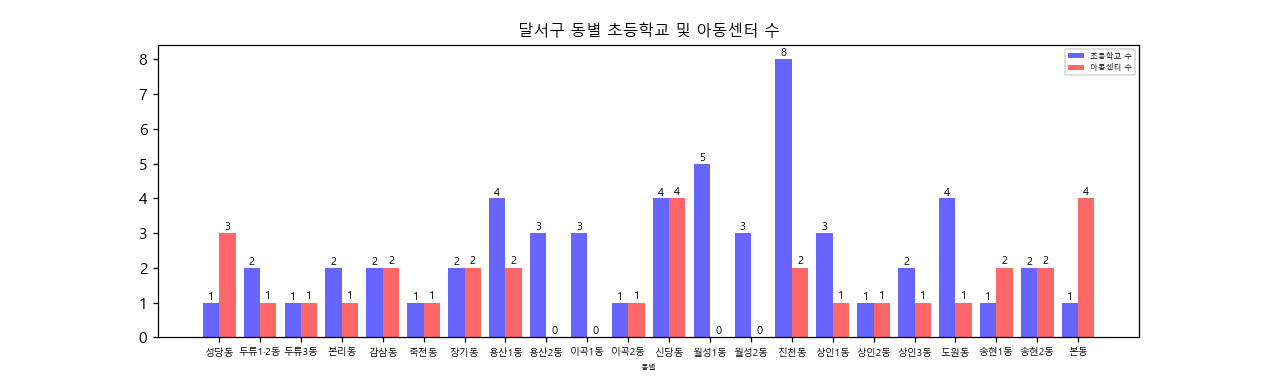

In [63]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot()
bar_width = 0.4
alpha = 0.6

p1 = plt.bar(index, school, bar_width, color='b', alpha=alpha, label='초등학교 수')

p2 = plt.bar(index + bar_width, center, bar_width, color='r', alpha=alpha, label='아동센터 수')

plt.title('달서구 동별 초등학교 및 아동센터 수', fontsize=10)

plt.ylabel('', fontsize=5)

plt.xlabel('동별', fontsize=5)

plt.xticks(index+0.2, label, fontsize=6.3)

plt.legend((p1[0], p2[0]), ('초등학교 수', '아동센터 수'), fontsize=5)


num_ele = list(result2['초등학교 수'])
num_cen = list(result2['아동센터 수'])

xtick_label_position = list(range(len(dong)))
# bars = plt.bar(xtick_label_position, num_patient, alpha=0.7, linewidth=3) ## 바차트 출력
 
for i, a in enumerate(p1):
    ax.text(a.get_x()+a.get_width()*(1/2),a.get_height()+0.08, num_ele[i],ha='center',fontsize=7)
    
for i, b in enumerate(p2):
      ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, num_cen[i],ha='center',fontsize=7)

plt.show()

## 시각화 (초등학생 인구수)

In [50]:
chi = pd.read_csv('격자별_초등학생인구수.csv', encoding = 'ansi' )

In [51]:
chi.dropna(axis=0, inplace = True)

In [53]:
g = chi.groupby('동별')

In [55]:
result3 = g.sum()[ ['인구수']]
result3 = result3.fillna(0).astype(int)
result3 = result3.reindex(["성당동", "두류1·2동", "두류3동","본리동","감삼동","죽전동","장기동","용산1동","용산2동","이곡1동","이곡2동","신당동","월성1동","월성2동","진천동","상인1동","상인2동","상인3동","도원동","송현1동","송현2동","본동"])

In [56]:
pop = result3.iloc[:,0]
index = np.arange(len(dong))

<IPython.core.display.Javascript object>


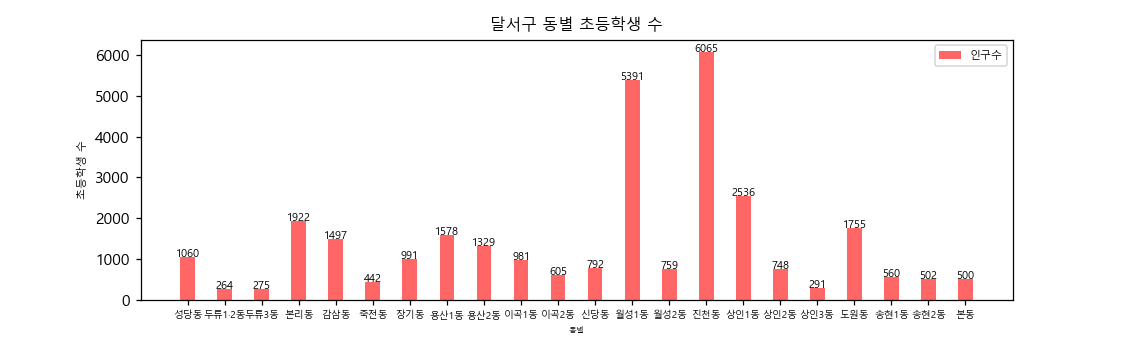

In [57]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot()
bar_width = 0.4
alpha = 0.6

p1 = plt.bar(index, pop, bar_width, color='r', alpha=alpha, label='초등학생 수')

plt.title('달서구 동별 초등학생 수', fontsize=10)

plt.ylabel('초등학생 수', fontsize=7)

plt.xlabel('동별', fontsize=5)

plt.xticks(index, label, fontsize=6.3)

plt.legend((p1[0], ), ('인구수', ), fontsize=7)


num_pop = list(result3['인구수'])

# xtick_label_position = list(range(len(dong)))

for i, a in enumerate(p1):
    ax.text(a.get_x()+a.get_width()*(1/2),a.get_height()+1, num_pop[i],ha='center',fontsize=7)
    
plt.show()

## 최종 이미지

In [64]:
from PIL import Image

In [65]:
image = Image.open("초등돌봄센터 최적입지선정 시각화.JPG")

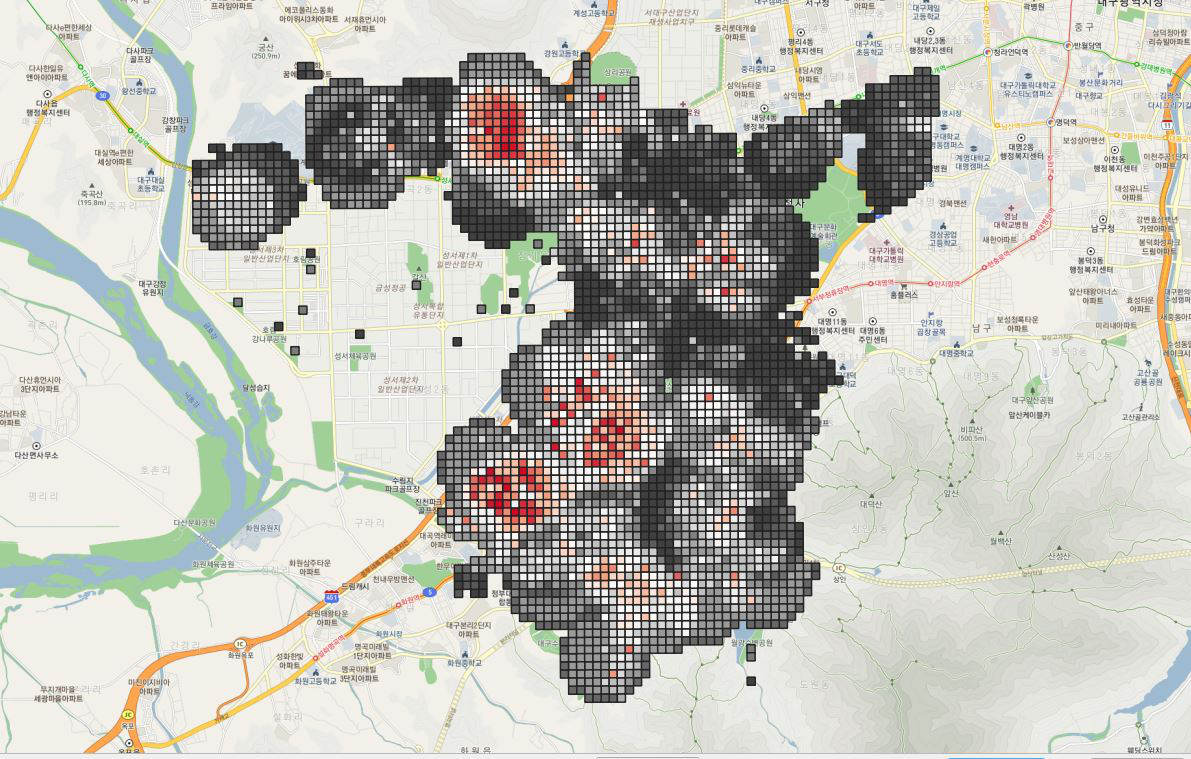

In [66]:
image